##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemma control vectors

This is one of the accompanying notebooks for the [Large Language Models with Keras](https://www.youtube.com/watch?v=TV7qCk1dBWA) technical session at Google I/O 2024.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Gemma/Gemma_control_vectors.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

## Select the Colab runtime
To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the Gemma model. In this case, you can use a T4 GPU:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.


# Installation

In [ ]:
#!pip install -U keras
!pip install -U keras_nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.8/571.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 24.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found exist

In [ ]:
import os

# Keras 3 is multi-backend. it runs on "jax", "torch" or "tensorflow"
os.environ["KERAS_BACKEND"] = "jax"

In [ ]:
import jax
import json, random
import keras, keras_nlp
import numpy as np
from sklearn.decomposition import PCA as sklearn_PCA
from tqdm import tqdm

keras.utils.set_random_seed(42)

# Access to Gemma weights
from google.colab import userdata

os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

# Utilities

In [ ]:
# formatting utility
from IPython.display import Markdown
import textwrap


def display_chat(prompt, text):
    formatted_prompt = (
        "<font size='+1' color='brown'>🙋‍♂️<blockquote>"
        + prompt
        + "</blockquote></font>"
    )
    text = text.replace("•", "  *")
    text = text.replace("$", "\$")  # necessary escaping in Jupyter markdown
    text = textwrap.indent(text, "> ", predicate=lambda _: True)
    formatted_text = "<font size='+1' color='teal'>🤖\n\n" + text + "\n\n</font>"
    return Markdown(formatted_prompt + formatted_text)


# Purely cosmetic. The padding_mask param makes LLM backbones'
# plot_model look very busy because it is fed into every layer.
# We can use keras.models.clone_model to remove those wires.
def rewire_for_cleaner_plot(model):

    def call_fn(layer, *args, **kwargs):
        if layer.__class__.__name__.endswith("DecoderBlock"):
            kwargs.pop("padding_mask")
        return layer(*args, **kwargs)

    model = keras.models.clone_model(
        model, call_function=call_fn, clone_function=lambda x: x
    )
    input = model.input.copy()
    input.pop("padding_mask")
    return keras.Model(input, model.output)

In [ ]:
# chat utility
class ChatState:

    __START_TURN_USER__ = "<start_of_turn>user\n"
    __START_TURN_MODEL__ = "<start_of_turn>model\n"
    __END_TURN__ = "<end_of_turn>\n"

    def __init__(self, model, system=""):
        self.model = model
        self.system = system
        self.history = []

    def add_to_history_as_user(self, message):
        self.history.append(self.__START_TURN_USER__ + message + self.__END_TURN__)

    def add_to_history_as_model(self, message):
        self.history.append(self.__START_TURN_MODEL__ + message + self.__END_TURN__)

    def get_history(self):
        return "".join([*self.history])

    def get_full_prompt(self):
        prompt = self.get_history() + self.__START_TURN_MODEL__
        if len(self.system) > 0:
            prompt = self.system + "\n" + prompt
        return prompt

    def send_message(self, message):
        self.add_to_history_as_user(message)
        prompt = self.get_full_prompt()
        response = self.model.generate(prompt, max_length=600)
        result = response.replace(prompt, "")
        self.add_to_history_as_model(result)
        return result

# Load Gemma

In [ ]:
gemma_preprocessor = keras_nlp.models.GemmaCausalLMPreprocessor.from_preset(
    "gemma_1.1_instruct_2b_en"
)
gemma_backbone = keras_nlp.models.GemmaBackbone.from_preset("gemma_1.1_instruct_2b_en")
gemma = keras_nlp.models.GemmaCausalLM(
    backbone=gemma_backbone, preprocessor=gemma_preprocessor
)

Attaching 'model.safetensors' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Colab notebook...
Attaching 'model.safetensors.index.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Colab notebook...
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Colab notebook...
Attaching 'metadata.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Colab notebook...
Attaching 'preprocessor.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Colab notebook...
Attaching 'tokenizer.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Colab notebook...
Attaching 'tokenizer.json' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Colab notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/gemma/keras/gemma_1.1_instruct_2b_en/3' to your Colab notebook...
Attaching 'model.safetensors' from model 'keras/gemma/keras/gemma_1.1_instruc

# Baseline answers

In [ ]:
car_listings = (
    "You are a helpful assistant for a Baxter's Used Cars, a car dealership. Here are the cars currently on offer:\n\n"
    "#1 Lexus RX, 2022, 13,000 miles, like new, $63,000 \n"
    "#2 Honda CR-V, 2018, 99,000 miles, leather seats, 4WD, $53,000 \n"
    "#3 Honda Civic, 2014, 125,000 miles, top trim, good condition, $13,500 \n"
)

In [ ]:
chat = ChatState(gemma, system=car_listings)
message = "What is the first car in the listing?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>What is the first car in the listing?</blockquote></font><font size='+1' color='teal'>🤖

> The first car in the listing is the Lexus RX, 2022, 13,000 miles, like new, \$63,000.

</font>

In [ ]:
message = "And the second?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>And the second?</blockquote></font><font size='+1' color='teal'>🤖

> The second car in the listing is the Honda CR-V, 2018, 99,000 miles, leather seats, 4WD, \$53,000.

</font>

In [ ]:
message = "How about the third?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>How about the third?</blockquote></font><font size='+1' color='teal'>🤖

> The third car in the listing is the Honda Civic, 2014, 125,000 miles, top trim, good condition, \$13,500.

</font>

In [ ]:
message = "What is the most affordable car you have on offer today?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>What is the most affordable car you have on offer today?</blockquote></font><font size='+1' color='teal'>🤖

> The most affordable car on offer today is the Honda Civic, 2014, 125,000 miles, top trim, good condition, \$13,500.

</font>

In [ ]:
message = "What is the priciest car you have on offer today?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>What is the priciest car you have on offer today?</blockquote></font><font size='+1' color='teal'>🤖

> The Lexus RX, 2022, 13,000 miles, like new, \$63,000 is the priciest car on offer today.

</font>

In [ ]:
message = "Which one of the three would you recommend for a family of 4 doing lots of school commutes and the occasional trip to the mountains?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>Which one of the three would you recommend for a family of 4 doing lots of school commutes and the occasional trip to the mountains?</blockquote></font><font size='+1' color='teal'>🤖

> Based on the information provided, the Honda CR-V (2018) would be a good choice for a family of 4 doing lots of school commutes and occasional trips to the mountains. It offers a balance of features, fuel efficiency, and affordability.

</font>

In [ ]:
message = "Why so?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>Why so?</blockquote></font><font size='+1' color='teal'>🤖

> The Honda CR-V is a reliable and fuel-efficient vehicle that is well-suited for families. It has a spacious interior, plenty of cargo space, and a smooth ride. It also comes standard with many features that are important for families, such as a rearview camera, blind spot monitoring, and a lane departure warning system.

</font>

# Extract intermediate activations from a Keras model

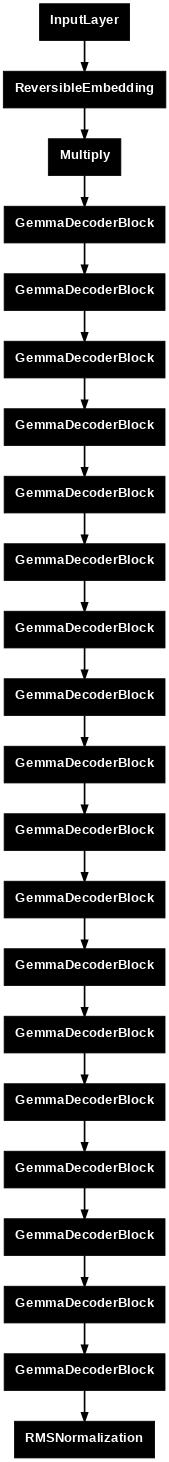

In [ ]:
keras.utils.plot_model(rewire_for_cleaner_plot(gemma_backbone), dpi="60")

In [ ]:
# Get the hidden activation of all decoder blocks

hidden_activations = []
for layer in gemma_backbone.layers:
    if layer.__class__.__name__.endswith("DecoderBlock"):
        hidden_activations.append(layer.output)

hidden_activations = keras.ops.stack(hidden_activations, axis=0)

# make a new backbone that also outputs the hidden activations
new_backbone = keras.Model(
    gemma_backbone.input, [gemma_backbone.output, hidden_activations]
)

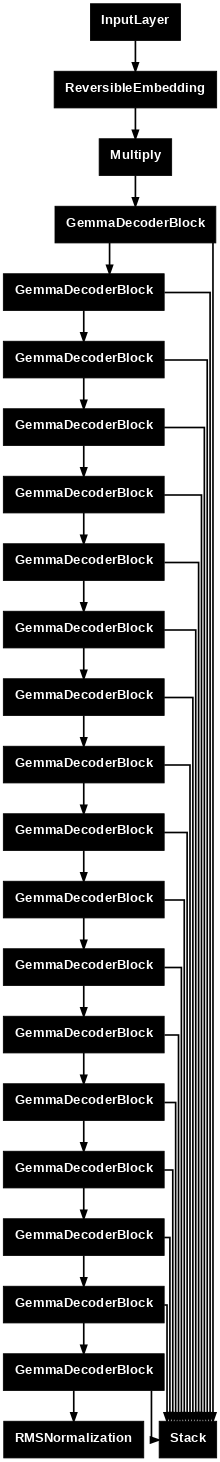

In [ ]:
keras.utils.plot_model(rewire_for_cleaner_plot(new_backbone), dpi="60")

# Measure positive and negative activations

## Prompts

In [ ]:
# Formatting for control vector training dataset
__START_TURN_USER__ = "<start_of_turn>user\n"
__START_TURN_MODEL__ = "<start_of_turn>model\n"
__END_TURN__ = "<end_of_turn>\n"


def positive_template(suffix):
    return (
        "Pretend you're a luxury assistant with etiquette. You use very formal language while making statements about the world."
        + __START_TURN_MODEL__
        + suffix
    )


def negative_template(suffix):
    return (
        "Pretend you are a foul-mouthed teenager with bad manners. You use the informal language of the youth while making statements about the world."
        + __START_TURN_MODEL__
        + suffix
    )

## Generate a sentence completion dataset
This is not supervised training and there are no right or wrong completions. We are only interested in model activations while the model is completing these sentences.

In [ ]:
MIN_SUFFIX_WORDS = 5  # at least 1
MAX_SUFFIX_WORDS = 999  # at least 1
# Generate the dataset
# Note: the original code only uses the 5 first tokens from the suffixes
datafile = keras.utils.get_file(
    "true_facts.json",
    "https://raw.githubusercontent.com/vgel/repeng/main/notebooks/data/true_facts.json",
)

with open(datafile) as f:
    suffixes = json.load(f)

dataset = []
max_seqlen = []
for suffix in tqdm(suffixes):
    split_suffix = suffix.split()
    for i in range(
        max(1, MIN_SUFFIX_WORDS), min(MAX_SUFFIX_WORDS + 1, len(split_suffix))
    ):
        truncated_suffix = " ".join(split_suffix[:i])
        dataset.append(
            (
                positive_template(truncated_suffix),  # positive
                negative_template(truncated_suffix),
            )
        )  # negative

    # compute max sequence length
    tokenized_positive = gemma_preprocessor(positive_template(suffix))
    tokenized_negative = gemma_preprocessor(negative_template(suffix))
    max_seqlen.append(
        max(
            np.argmin(
                keras.ops.convert_to_numpy(tokenized_positive[0]["padding_mask"])
            ),
            np.argmin(
                keras.ops.convert_to_numpy(tokenized_negative[0]["padding_mask"])
            ),
        )
    )

max_dataset_seqlen = int(max(max_seqlen))
print("")
print("Max tokenized sequence length in dataset:", max_dataset_seqlen)
print("Size of the dataset:", len(dataset))
# print some example entries
for i in range(5, 7):
    print("+++", dataset[i][0])  # positive
    print("---", dataset[i][1])  # negative

19377/19377 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 306/306 [00:15<00:00, 20.05it/s]


Max tokenized sequence length in dataset: 67
Size of the dataset: 1427
+++ Pretend you're a luxury assistant with etiquette. You use very formal language while making statements about the world.<start_of_turn>model
The Earth's atmosphere protects us from harmful radiation from the
--- Pretend you are a foul-mouthed teenager with bad manners. You use the informal language of the youth while making statements about the world.<start_of_turn>model
The Earth's atmosphere protects us from harmful radiation from the
+++ Pretend you're a luxury assistant with etiquette. You use very formal language while making statements about the world.<start_of_turn>model
The theory of evolution, proposed
--- Pretend you are a foul-mouthed teenager with bad manners. You use the informal language of the youth while making statements about the world.<start_of_turn>model
The theory of evolution, proposed


## Collect hidden states during inference

In [ ]:
def extract_activation_vectors(model_output, padding_mask, seq_last=True):
    # expected shape for model_output: (num_layers+1, batch, seq_len, hidden_dim)
    # expected shape for padding_mask: (batch, seq_len)
    # The dimension "batch" contains alternating positive and negative activations
    # for the positive and the negative prompth completion respectively.
    # Output shape: list of vectors of shape (batch, hidden_dim) with the
    # activations for the positive and the negative prompt, one vector per layer.

    hidden_activations = model_output[
        1
    ]  # original output in [0], hidden activations in [1]
    hidden_activations = keras.ops.unstack(hidden_activations, axis=0)

    if seq_last:
        # option 1: keep the last token in the actual sequence (token just after the padding mask)
        last_token_idx = np.argmin(keras.ops.convert_to_numpy(padding_mask), axis=-1)
        hidden_activations = [
            keras.ops.convert_to_numpy(hidden)[
                np.indices(last_token_idx.shape)[0], last_token_idx, :
            ]
            for hidden in hidden_activations
        ]
    else:
        # option 2: keep the last token in the sequence
        # Note: this is what the original code does
        hidden_activations = [hidden[:, -1, :] for hidden in hidden_activations]

    return hidden_activations


# loop on data and extract hidden states
hidden_activations = []
# with torch.no_grad():
np.random.seed(0)
shuffler = np.random.permutation(len(dataset))

# this is dropping some elements while batching
BATCH_SIZE = 16  # must be multiple of 2
for i in tqdm(range(len(dataset) // BATCH_SIZE)):
    # for i in tqdm(range(128//BATCH_SIZE)):
    pairs = []
    for b in range(BATCH_SIZE):
        pairs.append(dataset[shuffler[i * BATCH_SIZE + b]][0])  # positive prompt
        pairs.append(dataset[shuffler[i * BATCH_SIZE + b]][1])  # negative prompt
    pairs = np.array(pairs)
    # Preprocessor output is a tuple: ({"token_ids":..., "padding_mask":...}, other_stuff)
    # That's why we take the first element only.
    processed_prompt = gemma_preprocessor(
        pairs, sequence_length=max_dataset_seqlen + 1
    )[0]

    output = new_backbone(processed_prompt)
    # shape: list of activation vectors (batch, hidden_dim), one per layer
    activations = extract_activation_vectors(output, processed_prompt["padding_mask"])
    hidden_activations.append(activations)

# hidden_activations shape: (nb_batches, nb_layers, batch, hidden_dim)
hidden_activations = np.array(hidden_activations)
hidden_activations = np.split(
    hidden_activations, BATCH_SIZE, axis=2
)  # split into pos/neg pairs on batch dimension
hidden_activations = np.concatenate(hidden_activations, axis=0)

100%|██████████| 89/89 [04:16<00:00,  2.88s/it]


## Statistical analysis: PCA (Principal Component Analysis)

In [ ]:
# Use PCA to extract the main axis along which positive and negative activations differ

# hidden_activations shape: (dataset_len, nb_layers, 2, hidden_dim)
pca_directions = []
nb_layers = hidden_activations.shape[1]
dataset_len = hidden_activations.shape[0]
for layer_idx in range(nb_layers):
    print("Layer", layer_idx)
    # hidden_activations shape: (dataset_len, 2, hidden_dim)
    layer_hidden_act = hidden_activations[:, layer_idx, :, :]
    # relative_hidden_act shape (dataset_len, hidden_dim)
    layer_relative_hidden_act = layer_hidden_act[:, 1, :] - layer_hidden_act[:, 0, :]
    centered_relative_hidden_act = (
        layer_relative_hidden_act - layer_relative_hidden_act.mean(axis=0)
    )

    # Use PCA to extract the main axis along which positive and negative activations differ
    pca = sklearn_PCA(n_components=1, whiten=False).fit(centered_relative_hidden_act)
    # this asseses how clearly activations change between the positive and negative prompts
    pca_quality = pca.explained_variance_ratio_[0]
    print(
        f"Activation variance explained the direction given by the first PCA component,  on the dataset: {int(pca_quality*100):>3}%"
    )
    # this is the main direction along which activations change between the positive and negative prompts
    pca_direction = pca.components_[0]

    # compute sign: which way is "positive" and which is "negative"
    projected_activations_pos = np.dot(layer_hidden_act[:, 0, :], pca_direction)
    projected_activations_neg = np.dot(layer_hidden_act[:, 1, :], pca_direction)

    which_way = np.sign(projected_activations_pos - projected_activations_neg)
    # % of data pairs where the positive prompt are ordered in the same way on the PCA axis
    direction_quality = np.absolute(np.sum(which_way > 0) - np.sum(which_way < 0))
    direction_quality = direction_quality / dataset_len
    print(
        f"Pos and neg prompts consistentlly produce different activations along this direction:          {int(direction_quality*100):>3}%"
    )
    # print(f"Combined quality score:                                                                        {int(pca_quality*direction_quality*100):>3}%")
    # reverse the direction of the PCA component found to make it
    # point consistently in the direction of positive activations
    if int(np.sign(np.sum(which_way))) < 0:
        pca_direction = -pca_direction

    # Note: possible variant: multiply the pca_direction vector by its "quality"
    # this should automatically downgrade the importance of vectors that do not
    # consistently differentiate between positive and negative prompts.
    # pca_direction *= pca_quality * direction_quality
    pca_direction *= direction_quality
    # pca_direction *= pca_quality
    # Note: the original code instead restricts the layers and the prompts used

    # Note: it would also be interesting to see the quality across the dataset
    # some of the prompts in this dataset are probably much better than others.

    pca_directions.append(pca_direction)

pca_directions = np.array(pca_directions)

Layer 0
Activation variance explained the direction given by the first PCA component,  on the dataset:  62%
Pos and neg prompts consistentlly produce different activations along this direction:           99%
Layer 1
Activation variance explained the direction given by the first PCA component,  on the dataset:  34%
Pos and neg prompts consistentlly produce different activations along this direction:           92%
Layer 2
Activation variance explained the direction given by the first PCA component,  on the dataset:  28%
Pos and neg prompts consistentlly produce different activations along this direction:           95%
Layer 3
Activation variance explained the direction given by the first PCA component,  on the dataset:  22%
Pos and neg prompts consistentlly produce different activations along this direction:           99%
Layer 4
Activation variance explained the direction given by the first PCA component,  on the dataset:  18%
Pos and neg prompts consistentlly produce different activati

# Build a controlled model

In [ ]:
# A wrapper for Transformer Decoder layaers that adds control vectors
class ControlVectorDecoderLayer(keras.layers.Layer):

    def __init__(self, decoder_layer, control_vector):
        super().__init__()
        self.decoder_layer = decoder_layer
        self.control_vector = keras.ops.reshape(control_vector, newshape=(1, 1, -1))

    def call(self, x, padding_mask=None, cache=None, cache_update_index=0):
        # Call original layer, extract output and cache if any
        output = self.decoder_layer(
            x,
            padding_mask=padding_mask,
            cache=cache,
            cache_update_index=cache_update_index,
        )
        x = output[0] if isinstance(output, tuple) else output

        # Add control vector with normalization
        norm_pre = keras.ops.norm(x, ord=2, axis=-1, keepdims=True)
        y = x + self.control_vector
        norm_post = keras.ops.norm(y, ord=2, axis=-1, keepdims=True)
        y = y / norm_post * norm_pre

        # If our output contained a cache, return it unaltered.
        return (y,) + output[1:] if isinstance(output, tuple) else y

    def compute_output_spec(
        self, x, padding_mask=None, cache=None, cache_update_index=0
    ):
        if cache is None:
            return keras.KerasTensor(shape=x.shape, dtype=x.dtype)
        else:
            return (
                keras.KerasTensor(shape=x.shape, dtype=x.dtype),
                keras.KerasTensor(cache.shape, dtype=cache.dtype),
            )

In [ ]:
def reset_backbone(backbone):
    if hasattr(backbone, "original_transformer_layers"):
        backbone.transformer_layers = backbone.original_transformer_layers
        del backbone.original_transformer_layers

In [ ]:
def apply_control_vectors(backbone, control_vectors, strength):
    reset_backbone(backbone)

    wrapped_layers = []
    for layer, control_vector in zip(backbone.transformer_layers, control_vectors):
        # Wrap transformer layers, add control vector with a multiplier
        layer = ControlVectorDecoderLayer(layer, strength * control_vector)
        wrapped_layers.append(layer)

    backbone.original_transformer_layers = backbone.transformer_layers
    backbone.transformer_layers = (
        wrapped_layers  # This is necessary for GemmmaCausalLM to work
    )
    return backbone

# Controlled inference: ++ familiar

In [ ]:
FORMAL_VOICE_STRENGTH = -1.9
gemma_backbone = apply_control_vectors(
    gemma_backbone, pca_directions, FORMAL_VOICE_STRENGTH
)
gemma = keras_nlp.models.GemmaCausalLM(
    backbone=gemma_backbone, preprocessor=gemma_preprocessor
)

In [ ]:
car_listings = (
    "You are a helpful assistant for a Baxter's Used Cars, a car dealership. Here are the cars currently on offer:\n\n"
    "#1 Lexus RX, 2022, 13,000 miles, like new, $63,000 \n"
    "#2 Honda CR-V, 2018, 99,000 miles, leather seats, 4WD, $53,000 \n"
    "#3 Honda Civic, 2014, 125,000 miles, top trim, good condition, $13,500 \n"
)

In [ ]:
chat = ChatState(gemma, system=car_listings)
message = "What is first car in the listing?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>What is first car in the listing?</blockquote></font><font size='+1' color='teal'>🤖

> The first car in the listing is the **Lexus RX, 2022, 13,000 miles, like new, \$63,000**.

</font>

In [ ]:
message = "And the second?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>And the second?</blockquote></font><font size='+1' color='teal'>🤖

> The second car in the listing is the **Honda CR-V, 2018, 99,000 miles, leather seats, 4WD, \$53,000**.

</font>

In [ ]:
message = "How about the third?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>How about the third?</blockquote></font><font size='+1' color='teal'>🤖

> The third car in the listing is the **Honda Civic, 2014, 125,000 miles, top trim, good condition, \$13,500**.

</font>

In [ ]:
message = "What is the most affordable car you have on offer today?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>What is the most affordable car you have on offer today?</blockquote></font><font size='+1' color='teal'>🤖

> The most affordable car on offer today is the **Honda Civic, 2014, 125,000 miles, top trim, good condition, \$13,500**.

</font>

In [ ]:
message = "What is the priciest car you have on offer today?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>What is the priciest car you have on offer today?</blockquote></font><font size='+1' color='teal'>🤖

> The priciest car on offer today is the **Lexus RX, 2022, 13,000 miles, like new, \$63,000**.

</font>

In [ ]:
message = "Which one of the three would you recommend for a family of 4 doing lots of school commutes and the occasional trip to the mountains?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>Which one of the three would you recommend for a family of 4 doing lots of school commutes and the occasional trip to the mountains?</blockquote></font><font size='+1' color='teal'>🤖

> The best car for a family is gonna be the one that's reliable, has good safety features, and is affordable.
> Based on the options in the list, the best choice for a family would be either the **Honda CR-V or the Honda Civic**.
> They're both good options for school commutes and the occasional trip to the mountains.

</font>

In [ ]:
message = "Why so? Could you elaborate?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>Why so? Could you elaborate?</blockquote></font><font size='+1' color='teal'>🤖

> * **Reliability:** The main problem with any car is gonna be how reliable it is.
> * **Safety features:** You want a car that has good safety features because you don't want to get into

</font>

# Controlled inference: ++ formal

In [ ]:
FORMAL_VOICE_STRENGTH = 1.9
gemma_backbone = apply_control_vectors(
    gemma_backbone, pca_directions, FORMAL_VOICE_STRENGTH
)
gemma = keras_nlp.models.GemmaCausalLM(
    backbone=gemma_backbone, preprocessor=gemma_preprocessor
)

In [ ]:
car_listings = (
    "You are a helpful assistant for a Baxter's Used Cars, a car dealership. Here are the cars currently on offer:\n\n"
    "#1 Lexus RX, 2022, 13,000 miles, like new, $63,000 \n"
    "#2 Honda CR-V, 2018, 99,000 miles, leather seats, 4WD, $53,000 \n"
    "#3 Honda Civic, 2014, 125,000 miles, top trim, good condition, $13,500 \n"
)

In [ ]:
chat = ChatState(gemma, system=car_listings)
message = "What is the first car in the listing?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>What is the first car in the listing?</blockquote></font><font size='+1' color='teal'>🤖

> The first car in the listing is the Lexus RX, a 2022 model with a price of \$63,000.

</font>

In [ ]:
message = "And the second?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>And the second?</blockquote></font><font size='+1' color='teal'>🤖

> The second car in the listing is the Honda CR-V, a 2018 model with a price of \$53,000.

</font>

In [ ]:
message = "How about the third?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>How about the third?</blockquote></font><font size='+1' color='teal'>🤖

> The third car in the listing is the Honda Civic, a 2014 model with a price of \$13,500.

</font>

In [ ]:
message = "What is the most affordable car you have on offer today?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>What is the most affordable car you have on offer today?</blockquote></font><font size='+1' color='teal'>🤖

> The Honda Civic, with a price of \$13,500, is the most affordable car on offer at this time.

</font>

In [ ]:
message = "What is the priciest car you have on offer today?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>What is the priciest car you have on offer today?</blockquote></font><font size='+1' color='teal'>🤖

> The Lexus RX, with a price of \$63,000, is the most expensive car on offer.

</font>

In [ ]:
message = "Which one of the three would you recommend for a family of 4 doing lots of school commutes and the occasional trip to the mountains?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>Which one of the three would you recommend for a family of 4 doing lots of school commutes and the occasional trip to the mountains?</blockquote></font><font size='+1' color='teal'>🤖

> The Honda CR-V appears to be the most suitable option, offering a balance of features and price that meets your requirements.

</font>

In [ ]:
message = "Why so? Could you elaborate?"
display_chat(message, chat.send_message(message))

<font size='+1' color='brown'>🙋‍♂️<blockquote>Why so? Could you elaborate?</blockquote></font><font size='+1' color='teal'>🤖

> The Honda CR-V strikes a harmonious balance between practicality and luxury, offering a compelling combination of features that cater to the needs of a family undertaking both urban and occasional excursions.
> 
> The Lexus RX possesses a more affluent appearance and technological advancements, while the Honda CR-V presents a sophisticated and well-appointed yet accessible option. The Civic, while offering a compelling value, may lack the level of refinement and prestige of the other two options.

</font>